In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import os
import tensorflow as tf
from collections import Counter
import spacy
import pickle
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.saving import register_keras_serializable

In [3]:
# Hyperparameters
BATCH_SIZE = 4
EMBEDDING_DIM = 128
UNITS = 256
FREQ_THRESHOLD = 5
VALIDATION_SPLIT = 0.1
SEED = 42
EPOCHS = 5

In [4]:
# Paths
ROOT_FOLDER = "/home/devcontainers/Datasets/Images"
CAPTION_FILE = "/home/devcontainers/Datasets/captions.txt"
MODEL_PATH = "attention_caption_model.keras"
ENCODER_SAVE = "encoder_attention.keras"
DECODER_WEIGHTS = "decoder_attention_wts.weights.h5"
VOCAB_PATH = "vocab_attention.pkl"

In [5]:
# Constructing the vocabulary class for text processing and building the vocabulary
nlp = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.idx2word = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.idx = 4

    def tokenizer(self, text):
        return [token.text.lower() for token in nlp(text)]

    def build_vocab(self, sentences):
        frequencies = Counter()
        for sentence in sentences:
            frequencies.update(self.tokenizer(sentence))
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold and word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def numericalize(self, text):
        tokens = self.tokenizer(text)
        return [self.word2idx.get(t, self.word2idx["<unk>"]) for t in tokens]

Vocabulary size: 2994
  min: 3
  max: 42
  mean: 13.836361389197874
  median: 13.0
  80th: 17
  85th: 18
  90th: 19
  95th: 21
  98th: 23

Suggested max_length (covering ~90%): 19
Suggested max_length (covering ~95%): 21


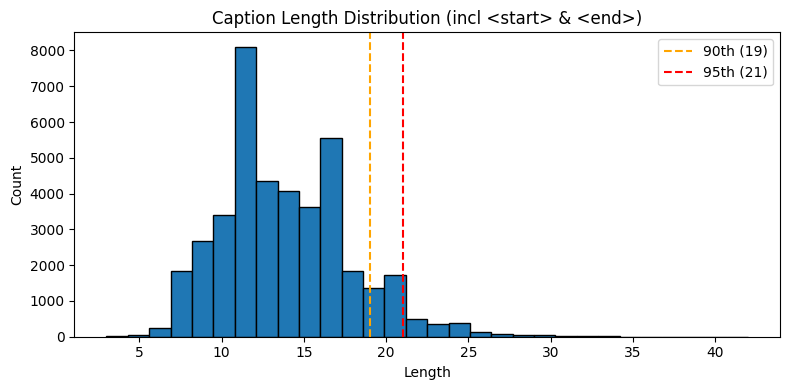

In [6]:
# Plotting the caption length distribution to determine max_length
root_folder = "/home/devcontainers/Datasets/Images"
caption_file = "/home/devcontainers/Datasets/captions.txt"
df = pd.read_csv(caption_file)
captions = df["caption"].astype(str).tolist()
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocab(captions)
print(f"Vocabulary size: {len(vocab.word2idx)}")

lengths = []
for cap in captions:
    token_ids = vocab.numericalize(cap)
    lengths.append(len(token_ids) + 2)
lengths = np.array(lengths)

summary = {
    "min": int(lengths.min()),
    "max": int(lengths.max()),
    "mean": float(np.mean(lengths)),
    "median": float(np.median(lengths)),
    "80th": int(np.percentile(lengths, 80)),
    "85th": int(np.percentile(lengths, 85)),
    "90th": int(np.percentile(lengths, 90)),
    "95th": int(np.percentile(lengths, 95)),
    "98th": int(np.percentile(lengths, 98)),
}

for k, v in summary.items():
    print(f"  {k}: {v}")
print(f"\nSuggested max_length (covering ~90%): {summary['90th']}")
print(f"Suggested max_length (covering ~95%): {summary['95th']}")

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=30, edgecolor="black")
plt.axvline(summary["90th"], color="orange", linestyle="--", label=f'90th ({summary["90th"]})')
plt.axvline(summary["95th"], color="red", linestyle="--", label=f'95th ({summary["95th"]})')
plt.title("Caption Length Distribution (incl <start> & <end>)")
plt.xlabel("Length")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
MAX_LENGTH = 19 

In [8]:
# Creating the dataset and preprocessing the images
def build_caption_pairs(captions, vocab, max_length):
    inputs = []
    targets = []
    for cap in captions:
        token_ids = vocab.numericalize(cap)
        caption = [vocab.word2idx["<start>"]] + token_ids + [vocab.word2idx["<end>"]]
        caption = caption[: max_length]
        pad_len = max_length - len(caption)
        caption += [vocab.word2idx["<pad>"]] * pad_len
        caption = np.array(caption, dtype=np.int32)
        inputs.append(caption[:-1])
        targets.append(caption[1:])
    return np.stack(inputs), np.stack(targets)

def preprocess_image_tensor(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    arr = np.array(img).astype(np.float32)
    arr = preprocess_input(arr)
    arr = np.expand_dims(arr, 0)
    return tf.convert_to_tensor(arr)

In [9]:
def make_datasets(df, vocab):
    captions = df["caption"].astype(str).tolist()
    images = df["image"].tolist()
    input_seqs, target_seqs = build_caption_pairs(captions, vocab, MAX_LENGTH)
    image_paths = np.array([os.path.join(ROOT_FOLDER, img) for img in images])
    train_img, val_img, train_inp, val_inp, train_tgt, val_tgt = train_test_split(image_paths, input_seqs, target_seqs, test_size=VALIDATION_SPLIT, random_state=SEED, shuffle=True)
    steps_per_epoch = math.ceil(len(train_img) / BATCH_SIZE)
    validation_steps = math.ceil(len(val_img) / BATCH_SIZE)

    def preprocess(path, inp, tgt):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)
        return (img, inp), tgt

    train_ds = (
        tf.data.Dataset.from_tensor_slices((train_img, train_inp, train_tgt))
        .map(lambda p, i, t: preprocess(p, i, t), num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )
    val_ds = (
        tf.data.Dataset.from_tensor_slices((val_img, val_inp, val_tgt))
        .map(lambda p, i, t: preprocess(p, i, t), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )
    return train_ds, val_ds, steps_per_epoch, validation_steps

In [10]:
# Registering the custom EncoderCNN class using MobileNetV2 for image feature extraction with Keras serialization to reconstruct the class later
@register_keras_serializable(package="custom", name="EncoderCNN")
class EncoderCNN(Model):
    def __init__(self, embedding_dim, train_backbone=False, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.train_backbone = train_backbone
        self.base = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")
        self.base.trainable = train_backbone
        self.fc = layers.Dense(embedding_dim)

    def call(self, x):
        x = self.base(x)
        return self.fc(x)

    def get_config(self):
        config = super().get_config()
        config.update({"embedding_dim": self.embedding_dim, "train_backbone": self.train_backbone})
        return config

    @classmethod
    def from_config(cls, config):
        embedding_dim = config.pop("embedding_dim")
        train_backbone = config.pop("train_backbone")
        return cls(embedding_dim=embedding_dim, train_backbone=train_backbone, **config)

In [11]:
# Registering the custom BahdanauAttention class for attention mechanism to know which parts of the image to focus on when generating captions
@register_keras_serializable(package="custom", name="BahdanauAttention")
class BahdanauAttention(Model):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_time))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config

    @classmethod
    def from_config(cls, config):
        units = config.pop("units")
        return cls(units=units, **config)

In [12]:
# Registering the custom DecoderRNN class for the decoder part of the model with attention mechanism
@register_keras_serializable(package="custom", name="DecoderRNN")
class DecoderRNN(Model):
    def __init__(self, vocab_size, embedding_dim, units, dropout_rate=0.3, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.units = units
        self.dropout_rate = dropout_rate
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.dropout_embed = layers.Dropout(dropout_rate)
        self.lstm = layers.LSTM(units, return_sequences=True, return_state=True)
        self.dropout_lstm = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(vocab_size)

    def call(self, x, features, hidden, cell, training=False):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = self.dropout_embed(x, training=training)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])
        output = self.dropout_lstm(output, training=training)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state_h, state_c, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))

    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "embedding_dim": self.embedding_dim,
            "units": self.units,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        vocab_size = config.pop("vocab_size")
        embedding_dim = config.pop("embedding_dim")
        units = config.pop("units")
        dropout_rate = config.pop("dropout_rate")
        return cls(vocab_size=vocab_size, embedding_dim=embedding_dim, units=units, dropout_rate=dropout_rate, **config)

In [13]:
# Registering the custom ImageCaptioningModel class to combine encoder and decoder with Keras serialization for reconstruction 
@register_keras_serializable(package="custom", name="ImageCaptioningModel")
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, encoder, decoder, vocab, max_length, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.vocab = vocab 
        self.max_length = max_length

    def call(self, inputs, training=False):
        img_tensor, input_seq = inputs
        batch_size = tf.shape(input_seq)[0]
        seq_len = tf.shape(input_seq)[1]
        features = self.encoder(img_tensor)
        hidden, cell = self.decoder.reset_state(batch_size)
        dec_input = tf.expand_dims(input_seq[:, 0], 1)
        outputs_ta = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        i = tf.constant(0)

        def cond(i, dec_input, hidden, cell, outputs_ta):
            return tf.less(i, seq_len)

        def body(i, dec_input, hidden, cell, outputs_ta):
            predictions, hidden, cell, _ = self.decoder(dec_input, features, hidden, cell, training=training)
            outputs_ta = outputs_ta.write(i, predictions)
            next_i = i + 1
            dec_input_next = tf.cond(
                tf.less(next_i, seq_len),
                lambda: tf.expand_dims(input_seq[:, next_i], 1),
                lambda: dec_input
            )
            return next_i, dec_input_next, hidden, cell, outputs_ta

        _, _, _, _, outputs_ta = tf.while_loop(
            cond, body,
            loop_vars=[i, dec_input, hidden, cell, outputs_ta],
            shape_invariants=[
                i.get_shape(),
                tf.TensorShape([None, 1]),
                tf.TensorShape([None, self.decoder.units]),
                tf.TensorShape([None, self.decoder.units]),
                tf.TensorShape(None)
            ]
        )
        outputs = outputs_ta.stack()
        outputs = tf.transpose(outputs, [1, 0, 2])
        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "max_length": self.max_length,
            "encoder": {
                "class_name": self.encoder.__class__.__name__,
                "config": self.encoder.get_config()
            },
            "decoder": {
                "class_name": self.decoder.__class__.__name__,
                "config": self.decoder.get_config()
            }
        })
        return config

    @classmethod
    def from_config(cls, config):
        max_length = config.pop("max_length")
        encoder_dict = config.pop("encoder")
        decoder_dict = config.pop("decoder")
        encoder = tf.keras.utils.deserialize_keras_object({"class_name": encoder_dict["class_name"], "config": encoder_dict["config"]})
        decoder = tf.keras.utils.deserialize_keras_object({"class_name": decoder_dict["class_name"], "config": decoder_dict["config"]})
        dummy_vocab = None
        return cls(encoder=encoder, decoder=decoder, vocab=dummy_vocab, max_length=max_length, **config)

In [14]:
# Custom masked loss function to handle padding tokens
def custom_loss(y_true, y_pred):
    loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
    loss = loss_obj(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, vocab.word2idx["<pad>"]), tf.float32)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [15]:
tf.keras.utils.set_random_seed(SEED)
df = pd.read_csv(CAPTION_FILE)
vocab = Vocabulary(freq_threshold=FREQ_THRESHOLD)
vocab.build_vocab(df["caption"].astype(str).tolist())
print(f"Vocab size: {len(vocab.word2idx)}")
train_ds, val_ds, steps_per_epoch, validation_steps = make_datasets(df, vocab)

encoder = EncoderCNN(embedding_dim=EMBEDDING_DIM, train_backbone=False)
decoder = DecoderRNN(vocab_size=len(vocab.word2idx), embedding_dim=EMBEDDING_DIM, units=UNITS)
model = ImageCaptioningModel(encoder, decoder, vocab, max_length=MAX_LENGTH)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_loss, metrics=["sparse_categorical_accuracy"])

callbacks = [
    ModelCheckpoint(MODEL_PATH, monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)
]

model.summary()

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=callbacks)

Vocab size: 2994


I0000 00:00:1754301346.128897    3362 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/tmp/ipykernel_3362/3237269027.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  self.base = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")


Model: "image_captioning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_cnn (EncoderCNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_rnn (DecoderRNN)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5


I0000 00:00:1754301361.221868    9854 cuda_dnn.cc:529] Loaded cuDNN version 90501


9103/9103 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 4.1086 - sparse_categorical_accuracy: 0.2008
Epoch 1: val_loss improved from inf to 3.31832, saving model to attention_caption_model.keras
9103/9103 ━━━━━━━━━━━━━━━━━━━━ 2334s 255ms/step - loss: 4.1085 - sparse_categorical_accuracy: 0.2008 - val_loss: 3.3183 - val_sparse_categorical_accuracy: 0.2512 - learning_rate: 0.0010
Epoch 2/5
9103/9103 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 3.3344 - sparse_categorical_accuracy: 0.2491
Epoch 2: val_loss improved from 3.31832 to 3.18078, saving model to attention_caption_model.keras
9103/9103 ━━━━━━━━━━━━━━━━━━━━ 2355s 259ms/step - loss: 3.3344 - sparse_categorical_accuracy: 0.2491 - val_loss: 3.1808 - val_sparse_categorical_accuracy: 0.2613 - learning_rate: 0.0010
Epoch 3/5
9103/9103 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 3.2009 - sparse_categorical_accuracy: 0.2572
Epoch 3: val_loss improved from 3.18078 to 3.12087, saving model to attention_caption_model.keras
9103/9103 ━━━━━━━━━━━━━━

In [16]:
# Saving the encoder, decoder weights, and vocabulary
model.save("final_caption_model.keras")
encoder.save(ENCODER_SAVE)
decoder.save_weights(DECODER_WEIGHTS)
with open(VOCAB_PATH, "wb") as f:
    pickle.dump(vocab, f)

In [ ]:
custom_objects = {
    "EncoderCNN": EncoderCNN,
    "DecoderRNN": DecoderRNN,
    "BahdanauAttention": BahdanauAttention,
    "ImageCaptioningModel": ImageCaptioningModel,
}

model = tf.keras.models.load_model("final_caption_model.keras", compile=False, custom_objects=custom_objects)

/tmp/ipykernel_3362/3237269027.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  self.base = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")


In [26]:
# Loading the model and vocab
# model = tf.keras.models.load_model("final_caption_model.keras", compile=False)
with open(VOCAB_PATH, "rb") as f:
    vocab = pickle.load(f)
model.vocab = vocab
img_tensor = preprocess_image_tensor("/home/devcontainers/Flask/img_captioning/notebooks/sample_image.jpg")

def greedy_decode(model, img_tensor, vocab):
    start = vocab.word2idx["<start>"]
    end = vocab.word2idx["<end>"]
    encoder = model.encoder
    decoder = model.decoder

    hidden, cell = decoder.reset_state(batch_size=1)
    features = encoder(img_tensor)
    dec_input = tf.expand_dims([start], 1)
    result = []

    for _ in range(MAX_LENGTH - 1):
        predictions, hidden, cell, _ = decoder(dec_input, features, hidden, cell, training=False)
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        if predicted_id == end:
            break
        result.append(vocab.idx2word.get(predicted_id, "<unk>"))
        dec_input = tf.expand_dims([predicted_id], 1)

    return " ".join(result)

def beam_search_decode(model, img_tensor, vocab, beam_width=3):
    start = vocab.word2idx["<start>"]
    end = vocab.word2idx["<end>"]
    encoder = model.encoder
    decoder = model.decoder
    
    features = encoder(img_tensor)
    hidden, cell = decoder.reset_state(batch_size=1)
    beams = [([start], hidden, cell, 0.0)]
    for _ in range(MAX_LENGTH - 1):
        candidates = []
        for seq, h, c, score in beams:
            if seq[-1] == end:
                candidates.append((seq, h, c, score))
                continue
            dec_input = tf.expand_dims([seq[-1]], 1)
            predictions, h, c, _ = decoder(dec_input, features, h, c, training = False)
            log_probs = tf.nn.log_softmax(predictions, axis = -1)[0].numpy()
            top_idxs = np.argsort(log_probs)[-beam_width:]
            for idx in top_idxs:
                new_seq = seq + [int(idx)]
                new_score = score + log_probs[idx]
                candidates.append((new_seq, h, c, new_score))
        beams = sorted(candidates, key = lambda x : x[3] / len(x[0]), reverse = True)[:beam_width]
        if all(b[0][-1] == end for b in beams):
            break
    best_seq = beams[0][0]
    tokens = [vocab.idx2word.get(i, "<unk>") for i in best_seq if i not in {start, end}]
    return " ".join(tokens)

caption_greedy = greedy_decode(model, img_tensor, vocab)
caption_beam = beam_search_decode(model, img_tensor, vocab, beam_width=3)
print(f"Greedy Caption: {caption_greedy}")
print(f"Beam Search Caption: {caption_beam}")

Greedy Caption: a man in a white shirt is walking on a beach .
Beam Search Caption: a dog is running through the grass .


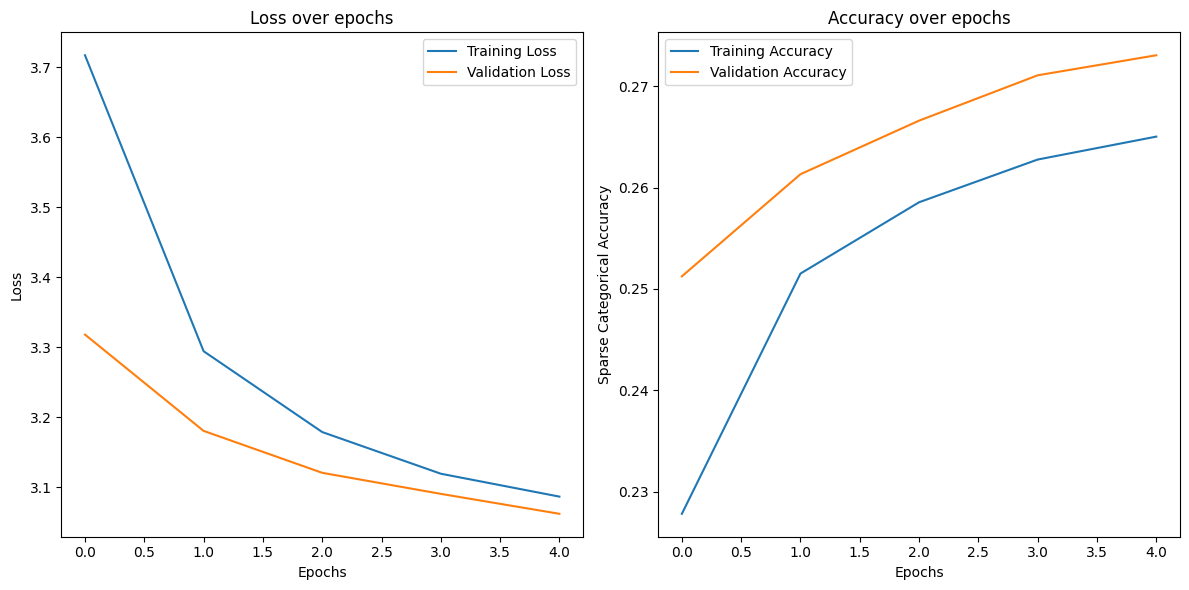

In [21]:
# Visualizing the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')    
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend()
plt.tight_layout()
plt.show()